In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import timm
import torch
import numpy as np

from PIL import Image
from pathlib import Path
from dotenv import load_dotenv
from timm.data.loader import create_loader
from timm.data.dataset import ImageDataset
import torchvision.transforms as transforms

import os
import json

from ViT.tooth_crop_dataset import ToothCropClassDataset
from utils.preprocess import rect_include_another, rotate_bounding_boxes, xyxy_reformat, xyxy2xywh
from utils.yolo import get_teeth_ROI
from utils.edge import tooth_isolation, bounding_teeth_on_origin, get_all_teeth

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline


# Model & env variable loaded

In [2]:
tooth_detect_model = torch.hub.load(r'.\YOLO', 'custom', path=r'.\YOLO\weights\8-bound.pt', source='local')
anomaly_detect_model = torch.hub.load(r'.\YOLO', 'custom', path=r'.\YOLO\weights\anomaly.pt', source='local')

# data_dir = '.' / Path(os.getenv('DATASET_DIR'))
data_dir = Path('..') / 'Datasets' / 'phase-2'


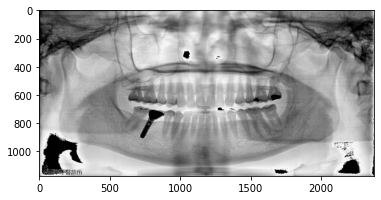

In [3]:
image_names = list(data_dir.glob('00008145.jpg'))

image_names = image_names[:20]
image_name = image_names[0]
filename = image_name.stem

im = cv2.imread(image_name)
# Only plt imshow need inverse process
plt.imshow(1 - im)
plt.show()


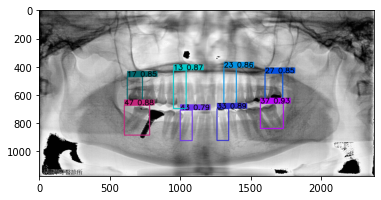

In [4]:
results = tooth_detect_model(image_names)
rendered_results = results.render()

plt.imshow(1 - rendered_results[0])
plt.show()


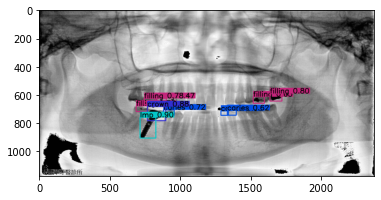

In [5]:
anomaly_results = anomaly_detect_model(image_names)
rendered_anomaly_results = anomaly_results.render()

plt.imshow(1 - rendered_anomaly_results[0])
plt.show()


In [6]:
results = tooth_detect_model(image_names)
teeth_region = get_all_teeth(results)
teeth_roi = get_teeth_ROI(results)

teeth_region
teeth_roi


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


{'images': {'00008145': [{'flag': 'upper',
    'number': 0,
    'tooth_position': 'left',
    'org_file_name': '00008145',
    'offset': array([684, 425]),
    'image': array([[[ 89,  89,  89],
            [ 88,  88,  88],
            [ 93,  93,  93],
            ...,
            [124, 124, 124],
            [125, 125, 125],
            [125, 125, 125]],
    
           [[ 92,  92,  92],
            [ 90,  90,  90],
            [ 91,  91,  91],
            ...,
            [129, 129, 129],
            [130, 130, 130],
            [129, 129, 129]],
    
           [[ 97,  97,  97],
            [ 94,  94,  94],
            [ 94,  94,  94],
            ...,
            [134, 134, 134],
            [134, 134, 134],
            [133, 133, 133]],
    
           ...,
    
           [[140, 140, 140],
            [133, 133, 133],
            [129, 129, 129],
            ...,
            [ 89,  89,  89],
            [ 87,  87,  87],
            [ 83,  83,  83]],
    
           [[138, 138, 138

# Save tooth crop image

In [7]:
temp_dir = '.' / Path(os.getenv('TEMP_DIR')) / 'crop_tooth_image'

missing_tooth = []
for file in temp_dir.glob('*.jpg'):
    os.remove(file)

for filename, region in teeth_region.items():
    for region_name, tooth_region in region.items():
        for tooth_number, data in tooth_region['crop_regions'].items():
            crop_image = data['crop_image']
            is_missing = data['is_missing']

            if is_missing:
                missing_tooth.append((filename, tooth_number))
                continue
            save_filepath = temp_dir / f'{filename} {region_name} {tooth_number}.jpg'

            temp_im = Image.fromarray(crop_image)
            temp_im.save(save_filepath)

# print(save_filepath)
missing_tooth


[]

# Model loading

In [8]:
model_dir = '.' / Path(os.getenv('ViT_MODEL_DIR'))
model_path = model_dir / 'classifier-6.pt'

vit_model = timm.create_model('swin_base_patch4_window7_224_in22k', num_classes=6)
vit_model.load_state_dict(torch.load(model_path))
vit_model


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate=none)
            (

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 16
num_workers = 0

# Preprocess
transform = transforms.Compose([
    transforms.ToTensor(),
    # (lambda image: padding_to_size(image, 224)),
    transforms.Resize(size=(224, 224)),
    transforms.Normalize(mean=0.5, std=0.5),
])
target_transform = transforms.Compose([
    (lambda y: torch.Tensor(y)),
])
dataset = ImageDataset(temp_dir, transform=transform)

if torch.cuda.is_available():
    dataloader = create_loader(dataset, (3, 224, 224), 4)
else:
    dataloader = create_loader(dataset, (3, 224, 224), 4, use_prefetcher=False)


In [10]:
size = len(dataloader.dataset)

vit_model.to(device)
vit_model.eval()

threshold = torch.Tensor([0.5, 0.85, 0.5, 0.5, 0.5, 0.5]).to(device)
pred_encodes = []
# target_labels = ['caries', 'endo', 'post', 'crown']
# target_labels = ['R.R', 'caries', 'crown', 'endo', 'filling', 'post']
target_labels = ['caries', 'crown', 'endo', 'filling', 'post']
with torch.no_grad():
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = vit_model(X)
        pred = torch.sigmoid(pred)
        pred_encode = pred > threshold
        pred_encodes.append(pred_encode.cpu().numpy())

pred_encodes = np.vstack(pred_encodes)
pred_encodes = pred_encodes[:, 1:]
detected_list = [()] * len(pred_encodes)
for i, pred_encode in enumerate(pred_encodes):
    detected_list[i] = tuple((target_labels[j] for j, checker in enumerate(pred_encode) if checker))

detected_list


[('filling',),
 (),
 ('post',),
 (),
 (),
 (),
 ('caries',),
 (),
 (),
 (),
 (),
 ('endo',),
 ('endo',),
 (),
 ('endo',),
 ('filling',),
 (),
 ('filling',),
 (),
 (),
 ('crown', 'endo', 'post'),
 ('endo',),
 ('endo',),
 ('crown', 'endo', 'post'),
 ('crown', 'endo', 'post'),
 (),
 ('crown', 'endo', 'post'),
 ('endo', 'post'),
 (),
 (),
 ()]

In [11]:
tooth_anomaly_dict = {anomaly_results.files[i][:-4]: {} for i in range(len(anomaly_results))}

for i, detected in enumerate(detected_list):
    current_filename, region_name, tooth_number = dataset.filename(i).split()
    tooth_number = int(tooth_number[:2])

    if tooth_number < 50:
        tooth_anomaly_dict[current_filename][tooth_number] = set(detected)

print(tooth_anomaly_dict)


{'00008145': {44: {'filling'}, 45: set(), 46: {'post'}, 31: set(), 32: set(), 41: set(), 42: {'caries'}, 34: set(), 35: set(), 36: set(), 13: set(), 17: {'endo'}, 23: {'endo'}, 27: set(), 33: {'endo'}, 37: {'filling'}, 43: set(), 47: {'filling'}, 15: set(), 16: set(), 11: {'post', 'endo', 'crown'}, 12: {'endo'}, 21: {'endo'}, 22: {'post', 'endo', 'crown'}, 24: set(), 25: set(), 26: set()}}


# YOLO anomaly detect


In [16]:
iou_threshold = 0.3
region_wisdom_tooth_dict = {
    'upper-left': 18,
    'upper-right': 28,
    'lower-left': 48,
    'lower-right': 38,
}

for i in range(len(anomaly_results)):
    current_filename = anomaly_results.files[i][:-4]
    anomaly_bounds = anomaly_results.xyxy[i]
    for j in range(len(anomaly_bounds)):
        *xyxy, _, cls = anomaly_bounds[j]
        xyxy = list(map(lambda t: t.cpu(), xyxy))

        cls = int(cls.item())
        name = anomaly_results.names[cls]
        # if name in target_labels:
        #     continue

        # for x8 tooth
        if name in ['embedded', 'impacted']:
            min_distance = np.inf
            near_region = ''
            for region_data in teeth_roi['images'][current_filename]:
                region_xyxy = region_data['xyxy']
                region_xywh = xyxy2xywh(np.vstack([region_xyxy]))[0]

                xywh = xyxy2xywh(np.vstack([xyxy]))[0]

                distance = np.linalg.norm(xywh[:2] - region_xywh[:2])
                if distance < min_distance:
                    min_distance = distance
                    near_region = f'{region_data["flag"]}-{region_data["tooth_position"]}'
            if near_region in region_wisdom_tooth_dict:
                tooth_number = region_wisdom_tooth_dict[near_region]
                if tooth_number not in tooth_anomaly_dict[current_filename].keys():
                    tooth_anomaly_dict[current_filename][tooth_number] = {name}
                else:
                    tooth_anomaly_dict[current_filename][tooth_number].add(name)
            continue

        # for normal tooth
        located_regions = {}
        for region_data in teeth_roi['images'][current_filename]:
            region_xyxy = region_data['xyxy']
            if rect_include_another(region_xyxy, xyxy) > iou_threshold:
                located_regions[f'{region_data["flag"]}-{region_data["tooth_position"]}'] = region_data

        for located_region, region_data in located_regions.items():
            region_tooth_data = teeth_region[current_filename][located_region]
            tooth_angle = np.radians(region_tooth_data['angle'])

            offset = region_data['offset']
            region_image_shape = np.array(np.array(region_data['image'].shape)[[1, 0]])

            rotated_xyxy = [xyxy]
            rotated_xyxy = np.array(rotated_xyxy) - np.tile(offset, 2)
            rotated_xyxy = rotate_bounding_boxes(tooth_angle, region_image_shape, rotated_xyxy)
            rotated_xyxy = rotated_xyxy[0].astype(int)

            tooth_number_candidate = []
            for tooth_number, tooth_data in region_tooth_data['crop_regions'].items():
                if tooth_number > 50:
                    continue

                tooth_xyxy = tooth_data['xyxy']
                # print(name)
                # print(rect_include_another(tooth_xyxy, rotated_xyxy))
                tooth_iou = rect_include_another(tooth_xyxy, rotated_xyxy)

                if tooth_iou > 0:
                    tooth_number_candidate.append((tooth_number, tooth_iou))

                # if rect_include_another(tooth_xyxy, rotated_xyxy) > iou_threshold:
                #     tooth_anomaly_dict[current_filename][tooth_number].add(name)
            if tooth_number_candidate:
                tooth_number, tooth_iou = max(tooth_number_candidate, key=lambda t: t[1])
                tooth_anomaly_dict[current_filename][tooth_number].add(name)


for pair in missing_tooth:
    filename, tooth_number = pair
    tooth_anomaly_dict[filename][tooth_number] = {'missing'}

print(tooth_anomaly_dict)


{'00008145': {44: {'filling', 'caries'}, 45: set(), 46: {'post', 'crown', 'Imp'}, 31: set(), 32: set(), 41: set(), 42: {'caries'}, 34: {'caries'}, 35: set(), 36: set(), 13: set(), 17: {'endo'}, 23: {'endo'}, 27: set(), 33: {'endo'}, 37: {'filling'}, 43: set(), 47: {'filling'}, 15: {'filling', 'crown'}, 16: {'filling'}, 11: {'post', 'endo', 'crown'}, 12: {'endo'}, 21: {'endo'}, 22: {'post', 'endo', 'crown'}, 24: set(), 25: set(), 26: {'filling'}}}


In [13]:
#
# with open('output.json', 'r') as f:
#     output = json.load(f)
# output[image_name.stem]





KeyError: '00008145'